# Faster RCNN İle Object Detection / Akvaryum



In [1]:
# ilk olarak google drive bağlantısı kuruyoruz.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np # lineer Cebir
import pandas as pd # veri işleme, CSV, excel vs. dosyası
import os # dosya işlemleri

Torchvision'un en son sürümüne ihtiyacımız var.

In [3]:
!pip install -U torchvision # Bu proje için yeni bir torchvision sürümüne ihtiyacımız var

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Gerekli kütüphanelerimizi import edelim.

In [4]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # veri artırma kitaplığımız 

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:

import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque # dictionary ve queue
import datetime 
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes # bounding box çizdirme

In [6]:
print(torch.__version__)
print(torchvision.__version__)

2.0.0+cu118
0.15.1+cu118


PyCOCOTools, COCO biçimindeki veri kümeleriyle başa çıkmak için birçok yardımcı program sağlar ve isterseniz, bu kitaplık ile sağlanan bazı yardımcı programlarla modelin veri kümesindeki performansını değerlendirebilirsiniz.

Ancak bu, bu defterin kapsamı dışındadır.

In [7]:
# veri setimiz cocoformat'ta, pycoco aracına ihtiyacımız olacak.
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
# Şimdi dönüşümlerimizi tanımlayacağız.
from albumentations.pytorch import ToTensorV2

We use albumentations as our data augmentation library due to its capability to deal with bounding boxes in multiple formats

In [9]:
def get_transforms(train=False):
    if train: # eğitimde veri artırma uyguluyoruz
        transform = A.Compose([ # albumentations kütüphanesindeki dönüşümler
            A.Resize(600, 600), # giriş boyutumuz 600 piksel olabilir
            A.HorizontalFlip(p=0.3), # 30% ihtimalle yatay çevir
            A.VerticalFlip(p=0.3), # 30% ihtimalle dikey çevir
            A.RandomBrightnessContrast(p=0.1), # 10% ihtimalle parlaklık ve kontrast değiştir
            A.ColorJitter(p=0.1), # 10% ihtimalle renk değiştir
            ToTensorV2() # albumentations kütüphanesindeki dönüşüm
        ], bbox_params=A.BboxParams(format='coco')) # bounding box formatı coco
    else: # test ve doğrulama için
        transform = A.Compose([ # albumentations kütüphanesindeki dönüşümler
            A.Resize(600, 600), # giriş boyutumuz 600 piksel olabilir
            ToTensorV2() # albumentations kütüphanesindeki dönüşüm
        ], bbox_params=A.BboxParams(format='coco')) # bounding box formatı coco
    return transform # dönüşümü döndür

## Dataset
Bu bizim veri kümesi sınıfımız. Gerekli tüm dosyaları yükler ve verileri modele beslenebilmesi için işler.

In [10]:
class AquariumDetection(datasets.VisionDataset): # VisionDataset sınıfından kalıtım alıyoruz
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None): # root: veri setinin bulunduğu klasör
        # veri kümeleri için 3 dönüştürme parametresi gereklidir.VisionDataset
        super().__init__(root, transforms, transform, target_transform) # VisionDataset sınıfından kalıtım aldığımız için super() kullanıyoruz
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # coco formatındaki etiket dosyası
        self.ids = list(sorted(self.coco.imgs.keys())) # resim id'leri
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)] # etiketlenmiş resimler
    
    def _load_image(self, id: int): # resim yükleme fonksiyonu
        path = self.coco.loadImgs(id)[0]['file_name'] # resim dosya adı
        image = cv2.imread(os.path.join(self.root, self.split, path)) # resmi oku
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # opencv'de resimler BGR formatında okunur, bunu RGB'ye çeviriyoruz
        return image # resmi döndür
    def _load_target(self, id): # etiket yükleme fonksiyonu
        return self.coco.loadAnns(self.coco.getAnnIds(id)) # id'ye göre etiketleri döndür
    
    def __getitem__(self, index): # index'teki resmi ve etiketleri döndür
        id = self.ids[index] # resim id'si
        image = self._load_image(id) # resmi yükle
        target = self._load_target(id) # etiketleri yükle
        target = copy.deepcopy(self._load_target(id)) # etiketleri kopyala
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # bounding box'ları ve kategorileri al
        if self.transforms is not None: # dönüşüm varsa
            transformed = self.transforms(image=image, bboxes=boxes) # resmi ve bounding box'ları dönüştür
        
        image = transformed['image'] # dönüştürülmüş resmi al
        boxes = transformed['bboxes'] # dönüştürülmüş bounding box'ları al
        
        new_boxes = [] # yeni bounding box'lar
        for box in boxes: # bounding box'ları dönüştür
            xmin = box[0] 
            xmax = xmin + box[2] 
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax]) # yeni bounding box'ları ekle
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32) # tensor'e çevir
        
        targ = {} # etiketler
        targ['boxes'] = boxes # bounding box'ları ekle
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64) # kategorileri ekle
        targ['image_id'] = torch.tensor([t['image_id'] for t in target]) # resim id'lerini ekle
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # bounding box'ların alanlarını hesapla
        targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64) # iscrowd etiketlerini ekle
        return image.div(255), targ # sınıflandırma için 0-1 arasında değerler döndürüyoruz
    def __len__(self): # veri setinin boyutunu döndür
        return len(self.ids) # resim id'lerinin sayısını döndür

In [11]:
dataset_path = "/content/drive/MyDrive/YyuYzYl/CV/Aquarium Combined" # veri setinin bulunduğu klasör

In [12]:
# veri setini yükle
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json")) # coco formatındaki etiket dosyası
categories = coco.cats # kategoriler
n_classes = len(categories.keys()) # 
categories

loading annotations into memory...
Done (t=8.35s)
creating index...
index created!


{0: {'id': 0, 'name': 'creatures', 'supercategory': 'none'},
 1: {'id': 1, 'name': 'fish', 'supercategory': 'creatures'},
 2: {'id': 2, 'name': 'jellyfish', 'supercategory': 'creatures'},
 3: {'id': 3, 'name': 'penguin', 'supercategory': 'creatures'},
 4: {'id': 4, 'name': 'puffin', 'supercategory': 'creatures'},
 5: {'id': 5, 'name': 'shark', 'supercategory': 'creatures'},
 6: {'id': 6, 'name': 'starfish', 'supercategory': 'creatures'},
 7: {'id': 7, 'name': 'stingray', 'supercategory': 'creatures'}}

Bu kod sadece sınıfların bir listesini alır

In [13]:
classes = [i[1]['name'] for i in categories.items()] # kategorilerin isimleri
classes

['creatures',
 'fish',
 'jellyfish',
 'penguin',
 'puffin',
 'shark',
 'starfish',
 'stingray']

In [14]:
train_dataset = AquariumDetection(root=dataset_path, transforms=get_transforms(True)) # eğitim veri seti

loading annotations into memory...
Done (t=0.05s)
creating index...
index created!


Bu örnek bir resim ve sınırlayıcı kutularıdır, bu kod modelin çıktısını almaz

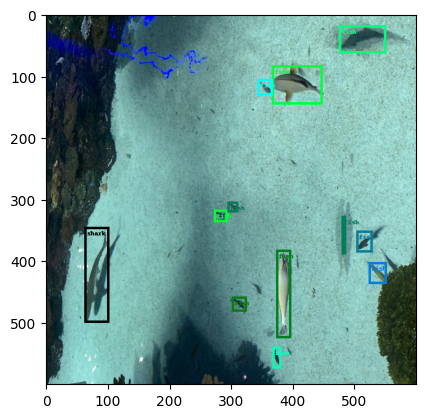

In [15]:
# veri setinden örnek resim çek
sample = train_dataset[1] # örnek resim
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8) # 0-1 arasındaki değerleri 0-255 arasına çevir
plt.imshow(draw_bounding_boxes( # bounding box'ları çiz
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4 # resim, bounding box'lar, kategoriler, çizgi kalınlığı
).permute(1, 2, 0)) # resmi göster, buradaki permute işlemi resmi göstermek için gereklidir ve görevi resmi RGB formatına çevirmektedir.

In [16]:
len(train_dataset) # veri setinin boyutunu görelim.

447

## Model

Modelimiz, MobileNetV3-Large omurgasına sahip FasterRCNN'dir. Çıktı katmanlarını değiştirmemiz gerekiyor çünkü sadece 7 sınıfımız var ama bu model 90 sınıf üzerinde eğitildi.

In [17]:

model = models.detection.fasterrcnn_mobilenet_v3_large_fpn(pretrained=True) # modeli yükle
in_features = model.roi_heads.box_predictor.cls_score.in_features # modelin giriş özelliklerini al
model.roi_heads.box_predictor = models.detection.faster_rcnn.FastRCNNPredictor(in_features, n_classes) # modelin çıkış özelliklerini değiştir

Downloading: "https://download.pytorch.org/models/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_mobilenet_v3_large_fpn-fb6a3cc7.pth
100%|██████████| 74.2M/74.2M [00:00<00:00, 226MB/s]


Bu, tren veri yükleyicisi için harmanlama işlevimizdir, modele kolayca aktarılabilecek veri yığınları oluşturmamızı sağlar.

In [18]:
def collate_fn(batch): # veri setini yığın haline getirme fonksiyonu
    return tuple(zip(*batch)) # veri setini yığın haline getir

In [19]:
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, num_workers=4, collate_fn=collate_fn) # veri setini yükle

Aşağıdaki bloklar, modelin verileri alabilmesini ve eğitim sırasında çökmemesini sağlar.

In [20]:
images,targets = next(iter(train_loader)) # veri setinden örnek resim çek
images = list(image for image in images) # resimleri listeye çevir
targets = [{k:v for k, v in t.items()} for t in targets] # etiketleri listeye çevir
output = model(images, targets) # modeli eğit ve çıkışını al

In [21]:
device = torch.device("cuda") # cihazı belirle, eğer varsa GPU'yu kullan yoksa CPU'yu kullan

In [22]:
model = model.to(device) # modeli cihaza göre ayarla

## Optimizer
Burada optimize ediciyi tanımlıyoruz. Dilerseniz LR Scheduler'ı da tanımlayabilirsiniz, ancak veri setimiz çok küçük olduğu için bu defter için gerekli değildir.

> Not, `lr_scheduler`ın uygulanma şekliyle ilgili birkaç hata var. Zamanlayıcıyı kullanmak istiyorsanız, bu hataları düzeltmeniz gerekecek.

In [23]:

params = [p for p in model.parameters() if p.requires_grad] # modelin eğitilecek parametrelerini al
optimizer = torch.optim.SGD(params, lr=0.01, momentum=0.9, nesterov=True, weight_decay=1e-4) # optimizasyon fonksiyonu
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[16, 22], gamma=0.1) # lr scheduler

In [24]:
import sys # sistem kütüphanesi

## Training

Aşağıdaki, modeli bir dönem için eğitecek bir işlevdir. Torchvision Nesne Algılama modellerinde yerleşik bir kayıp işlevi bulunur ve girişleri ve hedefleri iletirseniz kaybı otomatik olarak hesaplar.

In [25]:
def train_one_epoch(model, optimizer, loader, device, epoch): # bir epoch eğitim fonksiyonu
    model.to(device) # modeli cihaza göre ayarla
    model.train() # modeli eğitim moduna al
    
#     lr_scheduler = None
#     if epoch == 0:
#         warmup_factor = 1.0 / 1000 # do lr warmup
#         warmup_iters = min(1000, len(loader) - 1)
        
#         lr_scheduler = optim.lr_scheduler.LinearLR(optimizer, start_factor = warmup_factor, total_iters=warmup_iters)
    
    all_losses = [] # tüm kayıplar
    all_losses_dict = [] 
    
    for images, targets in tqdm(loader): # veri setini yükle
        images = list(image.to(device) for image in images) # resimleri cihaza göre ayarla
        targets = [{k: torch.tensor(v).to(device) for k, v in t.items()} for t in targets] # etiketleri cihaza göre ayarla
        
        loss_dict = model(images, targets) # modeli eğit ve çıkışını al
        losses = sum(loss for loss in loss_dict.values()) # tüm kayıpları topla
        loss_dict_append = {k: v.item() for k, v in loss_dict.items()} # kayıpları listeye ekle
        loss_value = losses.item() # kayıpları topla
        
        all_losses.append(loss_value) # kayıpları listeye ekle
        all_losses_dict.append(loss_dict_append) # kayıpları listeye ekle
        
        if not math.isfinite(loss_value): # eğer kayıp sonsuzsa
            print(f"Loss is {loss_value}, stopping trainig") # hata mesajı ver
            print(loss_dict) # hata mesajı ver
            sys.exit(1) # hata mesajı ver
        
        optimizer.zero_grad() # gradyanları sıfırla
        losses.backward() # gradyanları hesapla
        optimizer.step() # gradyanları güncelle
         
#         if lr_scheduler is not None:
#             lr_scheduler.step() # 
        
    all_losses_dict = pd.DataFrame(all_losses_dict) # bütün kayıplar listesini dataframe'e çevir, bu kısım kayıpları görselleştirmek için kullanılmıştır.
    print("Epoch {}, lr: {:.6f}, loss: {:.6f}, loss_classifier: {:.6f}, loss_box: {:.6f}, loss_rpn_box: {:.6f}, loss_object: {:.6f}".format(
        epoch, optimizer.param_groups[0]['lr'], np.mean(all_losses),
        all_losses_dict['loss_classifier'].mean(),
        all_losses_dict['loss_box_reg'].mean(),
        all_losses_dict['loss_rpn_box_reg'].mean(),
        all_losses_dict['loss_objectness'].mean()
    ))

10 Epochs should be enough to train this model for a high accuracy

In [ ]:
num_epochs=50 # epoch sayısı

for epoch in range(num_epochs): # epoch sayısı kadar eğitim yap
    train_one_epoch(model, optimizer, train_loader, device, epoch) # bir epoch eğitim fonksiyonunu çağır
#     lr_scheduler.step()

In [27]:
# our learning rate was too low, due to a lr scheduler bug. For this task, we wont need a scheudul.er

## Trying on sample Images

This is the inference code for the model. First, we set the model to evaluation mode and clear the GPU Cache. We also load a test dataset, so that we can use fresh images that the model hasn't seen.

In [28]:

model.eval() # modeli test moduna al
torch.cuda.empty_cache() # GPU belleğini boşalt

In [29]:
test_dataset = AquariumDetection(root=dataset_path, split="test", transforms=get_transforms(False)) # test veri setini yükle

loading annotations into memory...
Done (t=1.55s)
creating index...
index created!


In [30]:
img, _ = test_dataset[45] # test veri setinden örnek resim çek
img_int = torch.tensor(img*255, dtype=torch.uint8) 
with torch.no_grad(): # gradyanları hesaplamayı durdur
    prediction = model([img.to(device)]) # modeli test et ve çıkışını al
    pred = prediction[0] # çıkışı al

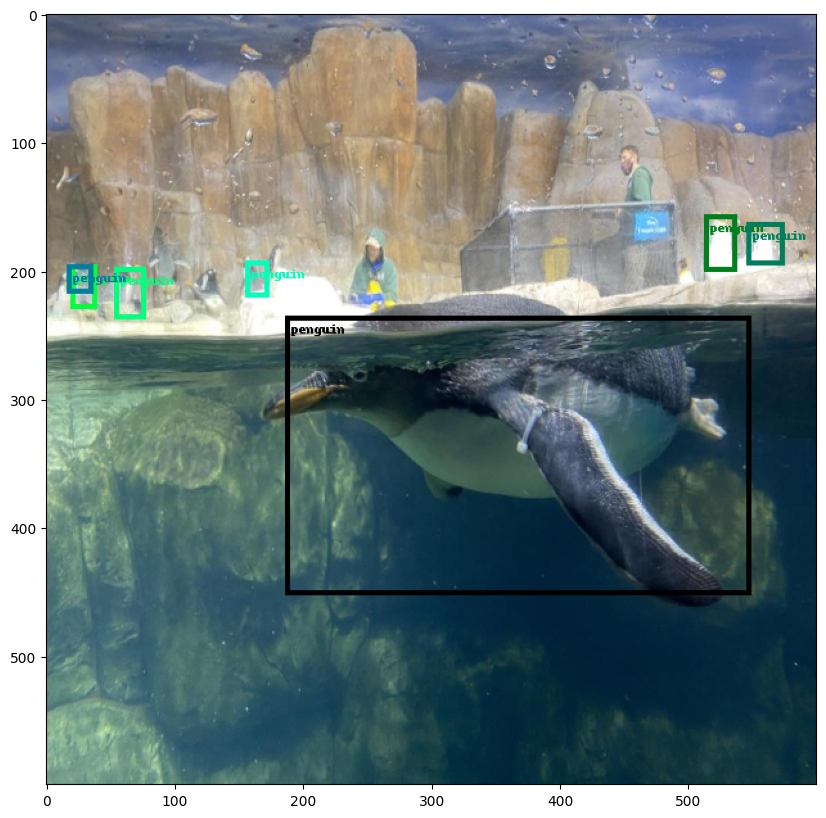

In [31]:
fig = plt.figure(figsize=(14, 10)) # resmi görselleştir
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8], # eğer skor 0.8'den büyükse etiketleri göster
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4 # eğer skor 0.8'den büyükse etiketleri göster
).permute(1, 2, 0)) # resmi görselleştir